# **Морозова Дарья, ИАД-3**

# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import sys

Загружаю датасет по совету из беседы флуда

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/dataset.zip"

In [ ]:
from torchvision.datasets import ImageFolder
import PIL
import torchvision.transforms as transforms
import random
random.seed(0)

# Аугментация Семинар 3
transforms1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor()
])

transforms2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

train_dataset = ImageFolder("./dataset/dataset/train", transform=transforms2)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transforms2)

Посмотрим на картинки:

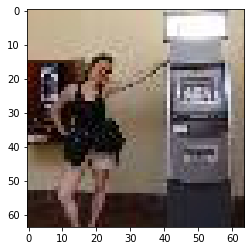

In [ ]:
import glob
import matplotlib.pyplot as plt
f = np.random.choice(glob.glob("./dataset/dataset/*/*/*.jpg"))
plt.imshow(plt.imread(f))

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


По примеру 5го семинара:

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    total_predictions = np.array([])  # список из предсказанных классов для каждого объекта из даталоадера
    total_labels = np.array([]) # список из настоящих классов для каждого объекта в даталоадере
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Обновляем описание для процесса
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)

            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
          
    predicted_classes, true_classes = total_predictions, total_labels
    return predicted_classes, true_classes
    # возвращает список из предсказанных классов для каждого объекта
    # из даталоадера и список из настоящих классов для каждого объекта в даталоадере
    

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()
    all_losses = [] # список лоссов по всем объектам 
    total_predictions = np.array([])  # список из предсказанных классов для каждого объекта из даталоадера
    total_labels = np.array([]) # список из настоящих классов для каждого объекта в даталоадере
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)

            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            all_losses.append(loss.detach().item())

    losses = all_losses
    predicted_classes, true_classes = total_predictions, total_labels
    return losses, predicted_classes, true_classes
    # возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта
    # из даталоадера и список из настоящих классов для каждого объекта в даталоадере


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)

    for epoch in range(n_epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        predicted_labels_tr, true_labels_tr = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device = device
        )
        # Выведем accuracy за 1 эпоху для Train
        accuracy_tr = accuracy_score(true_labels_tr, predicted_labels_tr)
        print("Train Accuracy for epoch {}: {}".format(epoch, accuracy_tr))

        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            eval_losses, predicted_labels, true_labels = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion,
                device = device
            )
        # Выведем accuracy за 1 эпоху для Eval
        accuracy = accuracy_score(true_labels, predicted_labels)
        print("Eval Accuracy for epoch {}: {}".format(epoch, accuracy))

**1 вариант:**

**первая аугментация (без нормализации) + предобученная vgg16 + оптимайзер RMSprop с lr = 1e-4**

В качетве модели попробуем предобученную vgg16:

In [ ]:
from torchvision.models import vgg16
model1 = vgg16(pretrained=True)
model1

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Замораживаем все параметры нейросети, чтобы модель их не обучала, т.к. она должна будет обучать только последний полносвязый слой

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

Заменяем последний полносвязный слой предобученной нейросети на линейный с 200 выходами (т.к. у нас 200 классов)

In [ ]:
model1.classifier[6] = nn.Linear(4096, 200, bias=True)

In [ ]:
random.seed(0)
model = model1 
optimizer1 = torch.optim.RMSprop(model.classifier[6].parameters(), lr=1e-4, momentum=0.9) # оптимизируем только последний полносвязный слой
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
scheduler = 1e-4   # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.3326 Accuracy: 0.0: 100%|██████████| 313/313 [01:36<00:00,  3.23it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer1, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 3.6792 Accuracy: 28.125: 100%|██████████| 3125/3125 [15:56<00:00,  3.27it/s]
Train Accuracy for epoch 0: 0.22631
Validation Epoch: 0
Loss: 3.1082 Accuracy: 25.0: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]
Eval Accuracy for epoch 0: 0.3294
Train Epoch: 1
Loss: 4.4081 Accuracy: 34.375: 100%|██████████| 3125/3125 [16:23<00:00,  3.18it/s]
Train Accuracy for epoch 1: 0.26843
Validation Epoch: 1
Loss: 2.1319 Accuracy: 50.0: 100%|██████████| 313/313 [01:38<00:00,  3.19it/s]
Eval Accuracy for epoch 1: 0.3514
Train Epoch: 2
Loss: 3.2931 Accuracy: 37.5: 100%|██████████| 3125/3125 [16:02<00:00,  3.25it/s]
Train Accuracy for epoch 2: 0.27821
Validation Epoch: 2
Loss: 3.1187 Accuracy: 31.25: 100%|██████████| 313/313 [01:37<00:00,  3.21it/s]
Eval Accuracy for epoch 2: 0.358
Train Epoch: 3
Loss: 3.6804 Accuracy: 40.625: 100%|██████████| 3125/3125 [16:04<00:00,  3.24it/s]
Train Accuracy for epoch 3: 0.28109
Validation Epoch: 3
Loss: 3.2384 Accuracy: 25.0: 100%|██████████| 3

Accuracy оказалось недстаточно :( попробуем изменить оптимайзер

**2 вариант:**

**вторая аугментация (с нормализацией) + предобученная vgg16 + оптимайзер Adam с lr = 1e-3**

In [ ]:
model1 = vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

model1.classifier[6] = nn.Linear(4096, 200, bias=True)

model = model1 
optimizer2 = torch.optim.Adam(model.classifier[6].parameters(), lr=1e-3)
scheduler = 1e-3

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer2, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 4.2913 Accuracy: 34.375: 100%|██████████| 3125/3125 [16:18<00:00,  3.19it/s]
Train Accuracy for epoch 0: 0.22636
Validation Epoch: 0
Loss: 2.4282 Accuracy: 31.25: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]
Eval Accuracy for epoch 0: 0.3265
Train Epoch: 1
Loss: 3.8038 Accuracy: 21.875: 100%|██████████| 3125/3125 [16:41<00:00,  3.12it/s]
Train Accuracy for epoch 1: 0.25986
Validation Epoch: 1
Loss: 3.5226 Accuracy: 25.0: 100%|██████████| 313/313 [01:39<00:00,  3.13it/s]
Eval Accuracy for epoch 1: 0.3407
Train Epoch: 2
Loss: 4.1743 Accuracy: 21.875: 100%|██████████| 3125/3125 [16:37<00:00,  3.13it/s]
Train Accuracy for epoch 2: 0.26635
Validation Epoch: 2
Loss: 2.2094 Accuracy: 50.0: 100%|██████████| 313/313 [01:40<00:00,  3.13it/s]
Eval Accuracy for epoch 2: 0.3502
Train Epoch: 3
Loss: 3.9898 Accuracy: 40.625: 100%|██████████| 3125/3125 [16:15<00:00,  3.20it/s]
Train Accuracy for epoch 3: 0.27173
Validation Epoch: 3
Loss: 2.171 Accuracy: 50.0: 100%|██████████|

На этой красивой ноте у меня слетела гпу из-за лимита коллаба :)))
Но и без окончания всех 10 эпох видно, что качества все еще не достаточно :( попробуем уменьшить lr

**3 вариант:**

Гпу вернулась!! продолжаем

**вторая аугментация (с нормализацией) + предобученый vgg + оптимайзер Adam с lr = 1e-4**

In [ ]:
model1 = vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

model1.classifier[6] = nn.Linear(4096, 200, bias=True)

model = model1 
optimizer3 = torch.optim.Adam(model.classifier[6].parameters(), lr=1e-4) 
scheduler = 1e-4

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer3, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 3.5293 Accuracy: 12.5: 100%|██████████| 3125/3125 [13:58<00:00,  3.73it/s]
Train Accuracy for epoch 0: 0.21423
Validation Epoch: 0
Loss: 3.5661 Accuracy: 12.5: 100%|██████████| 313/313 [01:24<00:00,  3.72it/s]
Eval Accuracy for epoch 0: 0.3143
Train Epoch: 1
Loss: 3.2928 Accuracy: 28.125: 100%|██████████| 3125/3125 [13:53<00:00,  3.75it/s]
Train Accuracy for epoch 1: 0.29929
Validation Epoch: 1
Loss: 3.2445 Accuracy: 37.5: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]
Eval Accuracy for epoch 1: 0.3467
Train Epoch: 2
Loss: 2.8201 Accuracy: 31.25: 100%|██████████| 3125/3125 [13:39<00:00,  3.82it/s]
Train Accuracy for epoch 2: 0.31934
Validation Epoch: 2
Loss: 2.9065 Accuracy: 25.0: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]
Eval Accuracy for epoch 2: 0.3639
Train Epoch: 3
Loss: 3.4781 Accuracy: 28.125: 100%|██████████| 3125/3125 [13:23<00:00,  3.89it/s]
Train Accuracy for epoch 3: 0.33081
Validation Epoch: 3
Loss: 2.1857 Accuracy: 43.75: 100%|██████████| 3

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {}".format(accuracy))

Loss: 2.7706 Accuracy: 18.75: 100%|██████████| 313/313 [01:21<00:00,  3.85it/s]
Accuracy: 0.4014


Качество заметно улучшилось, но такое ощущение, что из vgg большего не выжать (или надо ставить в 1,5-2 раза больше эпох, но на это времени уже нет). Иногда на отдельных объектах мелькала accuracy в районе 50-56, но, увы, картина в целом плоха.

Еще понижала lr до 1e-5, но тогда качество ужасное. lr=1e-4 было оптимальным для Адама с vgg.

Попробуем поменять модель:

**4 вариант:**

**вторая аугментация (с нормализацией) + предобученый resnet18 + оптимайзер Adam с lr = 1e-4** (т.к. такой lr лучше всего проявил себя ранее)

In [ ]:
from torchvision.models import resnet18
model2 = resnet18(pretrained=True)
model2

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заменяем последний полносвязный слой

In [ ]:
for param in model2.parameters():
    param.requires_grad = False

model2.fc = nn.Linear(512, 200)

model = model2 
optimizer4 = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = 1e-4

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer4, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 3.7663 Accuracy: 25.0: 100%|██████████| 3125/3125 [11:38<00:00,  4.47it/s]
Train Accuracy for epoch 0: 0.19172
Validation Epoch: 0
Loss: 3.8216 Accuracy: 25.0: 100%|██████████| 313/313 [01:07<00:00,  4.65it/s]
Eval Accuracy for epoch 0: 0.3401
Train Epoch: 1
Loss: 2.4343 Accuracy: 56.25: 100%|██████████| 3125/3125 [11:14<00:00,  4.64it/s]
Train Accuracy for epoch 1: 0.3742
Validation Epoch: 1
Loss: 3.3422 Accuracy: 31.25: 100%|██████████| 313/313 [01:07<00:00,  4.67it/s]
Eval Accuracy for epoch 1: 0.4189
Train Epoch: 2
Loss: 2.4869 Accuracy: 46.875: 100%|██████████| 3125/3125 [11:09<00:00,  4.67it/s]
Train Accuracy for epoch 2: 0.42378
Validation Epoch: 2
Loss: 3.1131 Accuracy: 37.5: 100%|██████████| 313/313 [01:06<00:00,  4.71it/s]
Eval Accuracy for epoch 2: 0.4451
Train Epoch: 3
Loss: 2.6862 Accuracy: 43.75: 100%|██████████| 3125/3125 [11:06<00:00,  4.69it/s]
Train Accuracy for epoch 3: 0.4463
Validation Epoch: 3
Loss: 1.6271 Accuracy: 75.0: 100%|██████████| 313/

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {}".format(accuracy))

Loss: 3.8082 Accuracy: 18.75: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s]
Accuracy: 0.5034


Эта модель оказалась лучшей

In [ ]:
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: 

Комментарии по моделям писала сразу после них.

В целом, любой оптимайзер работал лучше с lr=1e-4. При одинаковом lr лучше оптимизирует Адам, чем RMSprop (в прочем, не удивительно).

Resnet сила, vgg могила.

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# we will need this library to process the labeling
! pip install xmltodict

In [3]:
import xmltodict, json

Датасет мы за вас написали.

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [5]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # предсказания модели
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            # torch.from_numpy(image).to(device).float()
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [14]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 40 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
  model.to(device)
  for epoch in range(n_epochs):
    print("epoch {}/{}..".format(epoch, n_epochs))
    gl = train_one_epoch(model,train_dataloader, optimizer, device=device)
    mAP = evaluate(model, val_dataloader, device=device)
    print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

Скачиваю датасет так же через гугл диск

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -q "/content/drive/My Drive/archive.zip"

In [9]:
train_dataset0 = FruitDataset("./train_zip/train")
val_dataset0 = FruitDataset("./test_zip/test")
print(len(train_dataset0.images))
print(len(val_dataset0.images))

240
60


Скачаем библиотеку для аугментации

In [10]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-vg4_jaab
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-vg4_jaab
     |████████████████████████████████| 952kB 14.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72066 sha256=5efc63d9b8b3311db2a6bc73e825dae8baeedcb0d7cfbabed4526864b596374b
  Stored in directory: /tmp/pip-ephem-wheel-cache-v2tusa3t/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


По примеру 7го семинара:

In [11]:
def collate_fn(batch): # Для правильного формирования батчей, т.к. картинки могут быть разных размеров
    return tuple(zip(*batch))

In [51]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import random
import albumentations as A
from albumentations.pytorch import ToTensor
random.seed(11)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    A.RandomBrightnessContrast(p=0.6),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels']))
#bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}

val_transform = A.Compose([
    ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['labels'])) 
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)
# с batch_size=2 куда уж не справляется((

model = fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_classes = 4 # 3 фрукта и фон
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 10

In [52]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

epoch 0/10..
Loss value after 40 batches is 0.43
Loss value after 80 batches is 0.36
Loss value after 120 batches is 0.35
Loss value after 160 batches is 0.34
Loss value after 200 batches is 0.32
Loss value after 240 batches is 0.31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 0 is 0.768:
epoch 1/10..
Loss value after 40 batches is 0.25
Loss value after 80 batches is 0.27
Loss value after 120 batches is 0.25
Loss value after 160 batches is 0.25
Loss value after 200 batches is 0.26
Loss value after 240 batches is 0.24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 1 is 0.767:
epoch 2/10..
Loss value after 40 batches is 0.22
Loss value after 80 batches is 0.21
Loss value after 120 batches is 0.22
Loss value after 160 batches is 0.22
Loss value after 200 batches is 0.21
Loss value after 240 batches is 0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 2 is 0.863:
epoch 3/10..
Loss value after 40 batches is 0.18
Loss value after 80 batches is 0.21
Loss value after 120 batches is 0.21
Loss value after 160 batches is 0.19
Loss value after 200 batches is 0.19
Loss value after 240 batches is 0.19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 3 is 0.896:
epoch 4/10..
Loss value after 40 batches is 0.17
Loss value after 80 batches is 0.17
Loss value after 120 batches is 0.17
Loss value after 160 batches is 0.18
Loss value after 200 batches is 0.18
Loss value after 240 batches is 0.18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 4 is 0.904:
epoch 5/10..
Loss value after 40 batches is 0.15
Loss value after 80 batches is 0.15
Loss value after 120 batches is 0.16
Loss value after 160 batches is 0.16
Loss value after 200 batches is 0.16
Loss value after 240 batches is 0.16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 5 is 0.923:
epoch 6/10..
Loss value after 40 batches is 0.13
Loss value after 80 batches is 0.15
Loss value after 120 batches is 0.15
Loss value after 160 batches is 0.15
Loss value after 200 batches is 0.16
Loss value after 240 batches is 0.16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 6 is 0.895:
epoch 7/10..
Loss value after 40 batches is 0.15
Loss value after 80 batches is 0.14
Loss value after 120 batches is 0.14
Loss value after 160 batches is 0.14
Loss value after 200 batches is 0.15
Loss value after 240 batches is 0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 7 is 0.896:
epoch 8/10..
Loss value after 40 batches is 0.1
Loss value after 80 batches is 0.14
Loss value after 120 batches is 0.14
Loss value after 160 batches is 0.14
Loss value after 200 batches is 0.14
Loss value after 240 batches is 0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 8 is 0.891:
epoch 9/10..
Loss value after 40 batches is 0.11
Loss value after 80 batches is 0.12
Loss value after 120 batches is 0.13
Loss value after 160 batches is 0.14
Loss value after 200 batches is 0.14
Loss value after 240 batches is 0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

mAP after epoch 9 is 0.921:


__Выведите итоговое качество модели__.

In [53]:
mAP = evaluate(model, val_dataloader, device=device)
print(mAP)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * mAP / 0.91)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

0.9205766902194943
Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


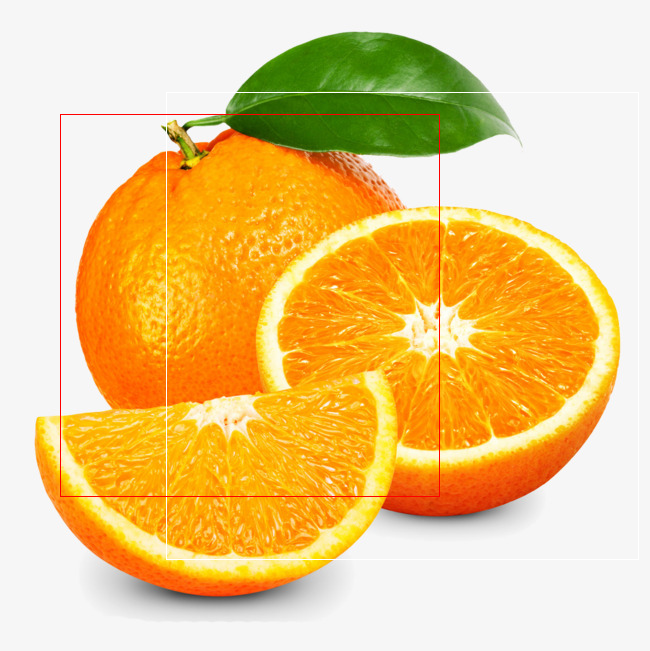

In [67]:
from PIL import ImageDraw
import torchvision.transforms as transforms

i = np.random.randint(0, len(val_dataset))
image, lbl = val_dataset[i]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

И еще случайная картинка:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


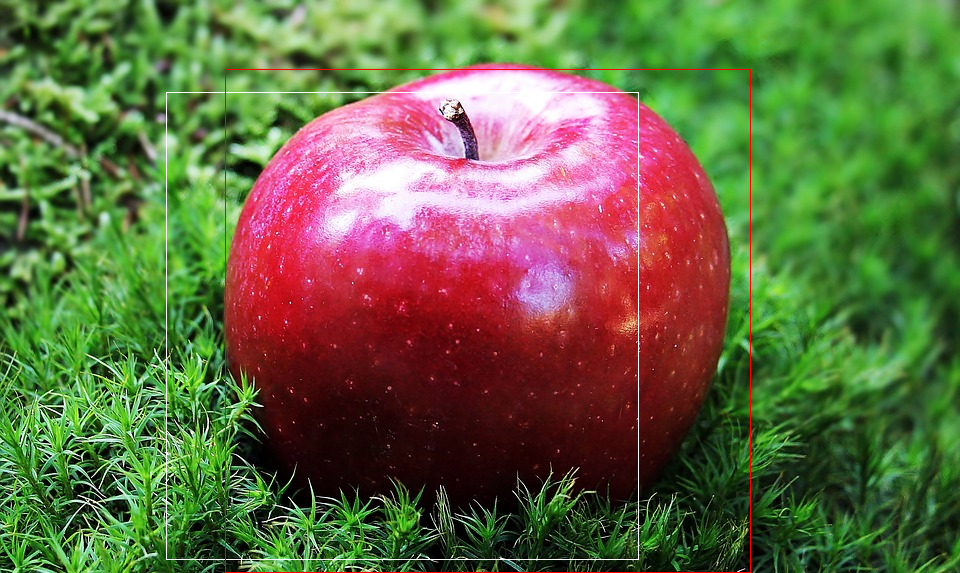

In [70]:
i = np.random.randint(0, len(val_dataset))
image, lbl = val_dataset[i]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Сначала в качестве оптимайзера я выбрала Адам, но на первой же эпохе качество было ужасным, поэтому сразу изменила его на сгд как в семинаре - помогло.

Примеры аугментации брала отсюда:
[https://pypi.org/project/albumentations/](https://pypi.org/project/albumentations/) и [https://colab.research.google.com/drive/1JuZ23u0C0gx93kV0oJ8Mq0B6CBYhPLXy#scrollTo=8H4FnMgNdR7A&forceEdit=true&sandboxMode=true](https://colab.research.google.com/drive/1JuZ23u0C0gx93kV0oJ8Mq0B6CBYhPLXy#scrollTo=8H4FnMgNdR7A&forceEdit=true&sandboxMode=true) (нашла их в гайде).
Некоторые аугментации сразу крашили модель. С оставшимися аугментациями довольно быстро добивается нужное качество. Пару раз меняла параметры в фунциях аугментации (повышала p в A.RandomBrightnessContrast(), добавляла параметры в A.ShiftScaleRotate) - эти запуски оставлять не стала (однако качество в них было неплохим - очень близко к 0,91, но мне не хотелось терять даже 0,1 итоговой оценки:)))). Обучилось довольно быстро.

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

Резнет дал хорошие результаты - acc до 0.5. Попробуем обучиться на версии резнета покруче:

In [ ]:
from torchvision.models import wide_resnet50_2
model3 = wide_resnet50_2(pretrained=True)
model3

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
for param in model3.parameters():
    param.requires_grad = False

model3.fc = nn.Linear(2048, 200)

model = model3 
optimizer4 = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
scheduler = 1e-4

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer4, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 3.164 Accuracy: 46.875: 100%|██████████| 3125/3125 [14:54<00:00,  3.49it/s]
Train Accuracy for epoch 0: 0.26892
Validation Epoch: 0
Loss: 3.3141 Accuracy: 31.25: 100%|██████████| 313/313 [01:26<00:00,  3.61it/s]
Eval Accuracy for epoch 0: 0.4138
Train Epoch: 1
Loss: 2.828 Accuracy: 43.75: 100%|██████████| 3125/3125 [14:20<00:00,  3.63it/s]
Train Accuracy for epoch 1: 0.42904
Validation Epoch: 1
Loss: 2.8404 Accuracy: 31.25: 100%|██████████| 313/313 [01:24<00:00,  3.69it/s]
Eval Accuracy for epoch 1: 0.4678
Train Epoch: 2
Loss: 2.4709 Accuracy: 40.625: 100%|██████████| 3125/3125 [14:07<00:00,  3.69it/s]
Train Accuracy for epoch 2: 0.46659
Validation Epoch: 2
Loss: 2.7216 Accuracy: 37.5: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]
Eval Accuracy for epoch 2: 0.4944
Train Epoch: 3
Loss: 1.8173 Accuracy: 65.625: 100%|██████████| 3125/3125 [14:03<00:00,  3.70it/s]
Train Accuracy for epoch 3: 0.4859
Validation Epoch: 3
Loss: 2.2717 Accuracy: 43.75: 100%|██████████| 

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {}".format(accuracy))

Loss: 1.5279 Accuracy: 68.75: 100%|██████████| 313/313 [01:28<00:00,  3.53it/s]
Accuracy: 0.5302


Модель оказалась довольно сильной - уже с 0 эпохи accuracy на Eval стала больше 0,41, а под конец вообще больше 0,52 как на Train, так и на Eval. Ни одна модель до этого не давала таких результатов. 

В обычном resner18 четыре слоя с двумя базовыми блоками в каждом. В wild resnet же в четырех блоках находятся от 3 до 5 базовых блоков - эта архитектура сложнее. Обучалась же она не на много дольше, чем resner18.

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

***me and my friends doing our DL hw:***

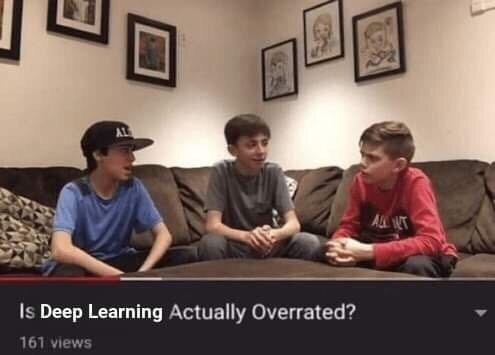

Домашка была технически намного легче первой - это понравилось :) только во второй ее части пришлось денек покапаться в коде из-за непоняток с аугментацией и очепятками в уже данном коде. Из неприятного еще было ждать обучние моделей в 1й части (сначала я терплю, терплю, а потом тоже терплю, терплю) (мб все же стоило писать свой датасет для ускорения, ху ноуз, кому-то это помогло, кому-то нет). Но несмотря на все, это дз и первое - небо и земля.